In [15]:
! pip install leidenalg

  Using cached igraph-0.11.8-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.8 kB)
Using cached igraph-0.11.8-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.1 MB)


In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import warnings


sc.set_figure_params(dpi=100)
warnings.filterwarnings('ignore')
sc.set_figure_params(scanpy=True, dpi=100)

adata = sc.read_10x_mtx('GSE149689', var_names='gene_symbols')

In [2]:
barcodes = adata.obs_names
subject = []
for each in barcodes:
    subject.append(each.split('-')[1])
adata.obs['subject_id'] = subject


The suffix of each barcode sequence represents patient information.
- '-1' - 'Sample1' - 'nCoV 1 scRNA-seq'
- '-2' - 'Sample2' - 'nCoV 2 scRNA-seq'
- '-3' - 'Sample3' - 'Flu 1 scRNA-seq'
- '-4' - 'Sample4' - 'Flu 2 scRNA-seq'
- '-5' - 'Sample5' - 'Normal 1 scRNA-seq'
- '-6' - 'Sample6' - 'Flu 3 scRNA-seq'
- '-7' - 'Sample7' - 'Flu 4 scRNA-seq'
- '-8' - 'Sample8' - 'Flu 5 scRNA-seq'
- '-9' - 'Sample9' - 'nCoV 3 scRNA-seq'
- '-10' - 'Sample10' - 'nCoV 4 scRNA-seq'
- '-11' - 'Sample11' - 'nCoV 5 scRNA-seq'
- '-12' - 'Sample12' - 'nCoV 6 scRNA-seq'
- '-13' - 'Sample13' - 'Normal 2 scRNA-seq'
- '-14' - 'Sample14' - 'Normal 3 scRNA-seq'
- '-15' - 'Sample15' - 'nCoV 7 scRNA-seq'
- '-16' - 'Sample16' - 'nCoV 8 scRNA-seq'
- '-17' - 'Sample17' - 'nCoV 9 scRNA-seq'
- '-18' - 'Sample18' - 'nCoV 10 scRNA-seq'
- '-19' - 'Sample19' - 'Normal 4 scRNA-seq'
- '-20' - 'Sample20' - 'nCoV 11 scRNA-seq'|

In [3]:
covid_subjects = ['1','2','9','10','11','12','15','16','17','18','20']
normal_subjects = ['5','13','14','19']

In [4]:
adata.obs['subject_id'].value_counts()

subject_id
2     7731
14    6574
1     6455
5     6426
11    6398
12    6283
13    6156
3     5851
19    5542
20    4868
16    4371
18    3984
6     3516
15    2349
8     2001
17    1755
4     1724
7     1455
10    1167
9      538
Name: count, dtype: int64

In [5]:
covid = adata[adata.obs['subject_id'].isin(covid_subjects)]
normal = adata[adata.obs['subject_id'].isin(normal_subjects)]

In [6]:
covid.obs['Condition'] = 'covid'
normal.obs['Condition'] = 'normal'

In [ ]:
covid.obs['subject_id'].value_counts()

subject_id
2     7731
1     6455
11    6398
12    6283
20    4868
16    4371
18    3984
15    2349
17    1755
10    1167
9      538
Name: count, dtype: int64

: 

In [7]:
adata = covid.concatenate(normal)

In [8]:
sc.pp.filter_cells(adata, min_genes=200) #filter cells with less than 200 genes
sc.pp.filter_genes(adata, min_cells=3) #filter genes expressed in less than 3 cells

In [9]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True) #calculate QC metrics

In [7]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

KeyError: "Could not find keys '['n_genes_by_counts', 'pct_counts_mt', 'total_counts']' in columns of `adata.obs` or in adata.var_names."

In [10]:
adata = adata[adata.obs.n_genes_by_counts < 3000, :] #filter out cells with more than 2500 genes
adata = adata[adata.obs.pct_counts_mt < 12, :] #filter out cells with more than 5% mitochondrial counts

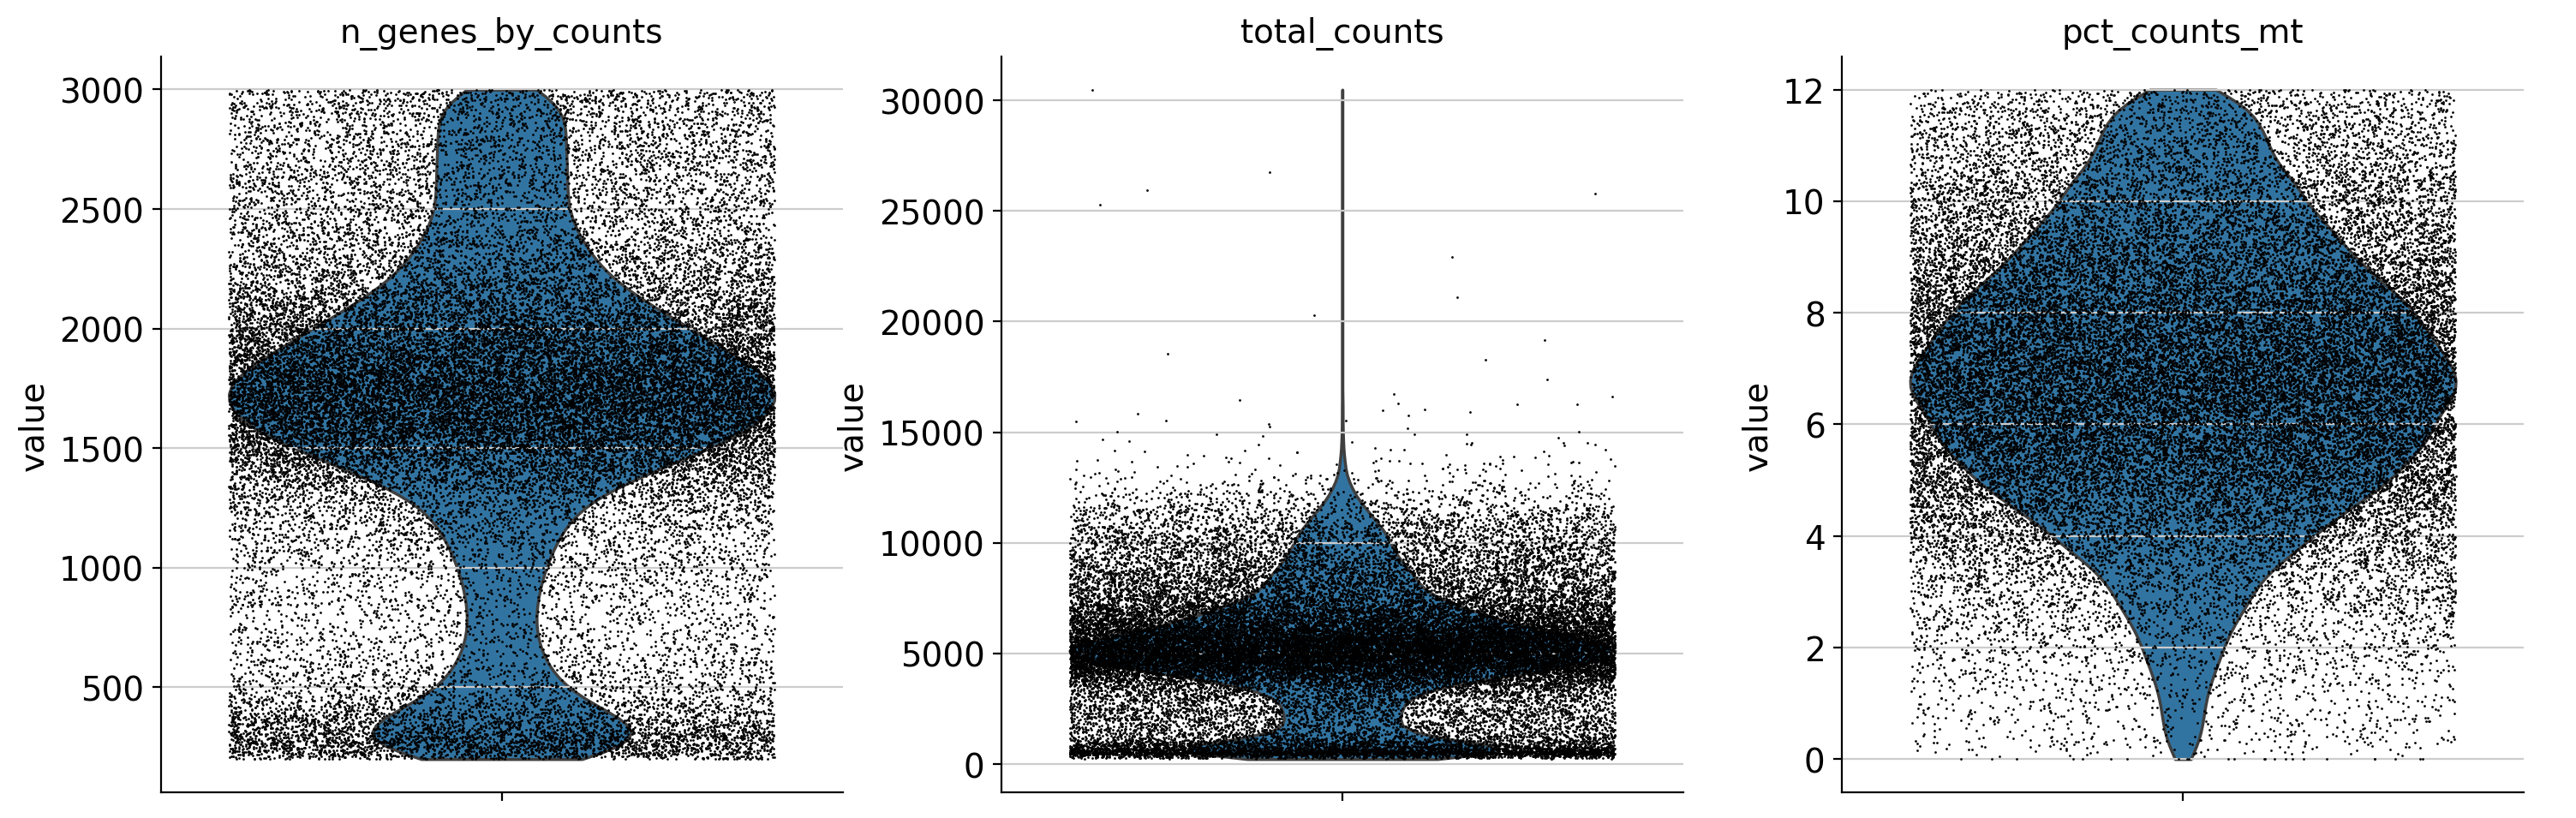

: 

In [ ]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

In [11]:
adata = adata[adata.obs.n_genes_by_counts > 1000, :] #filter out cells with more than 2500 genes
adata = adata[adata.obs.pct_counts_mt > 2, :] #filter out cells with more than 5% mitochondrial counts

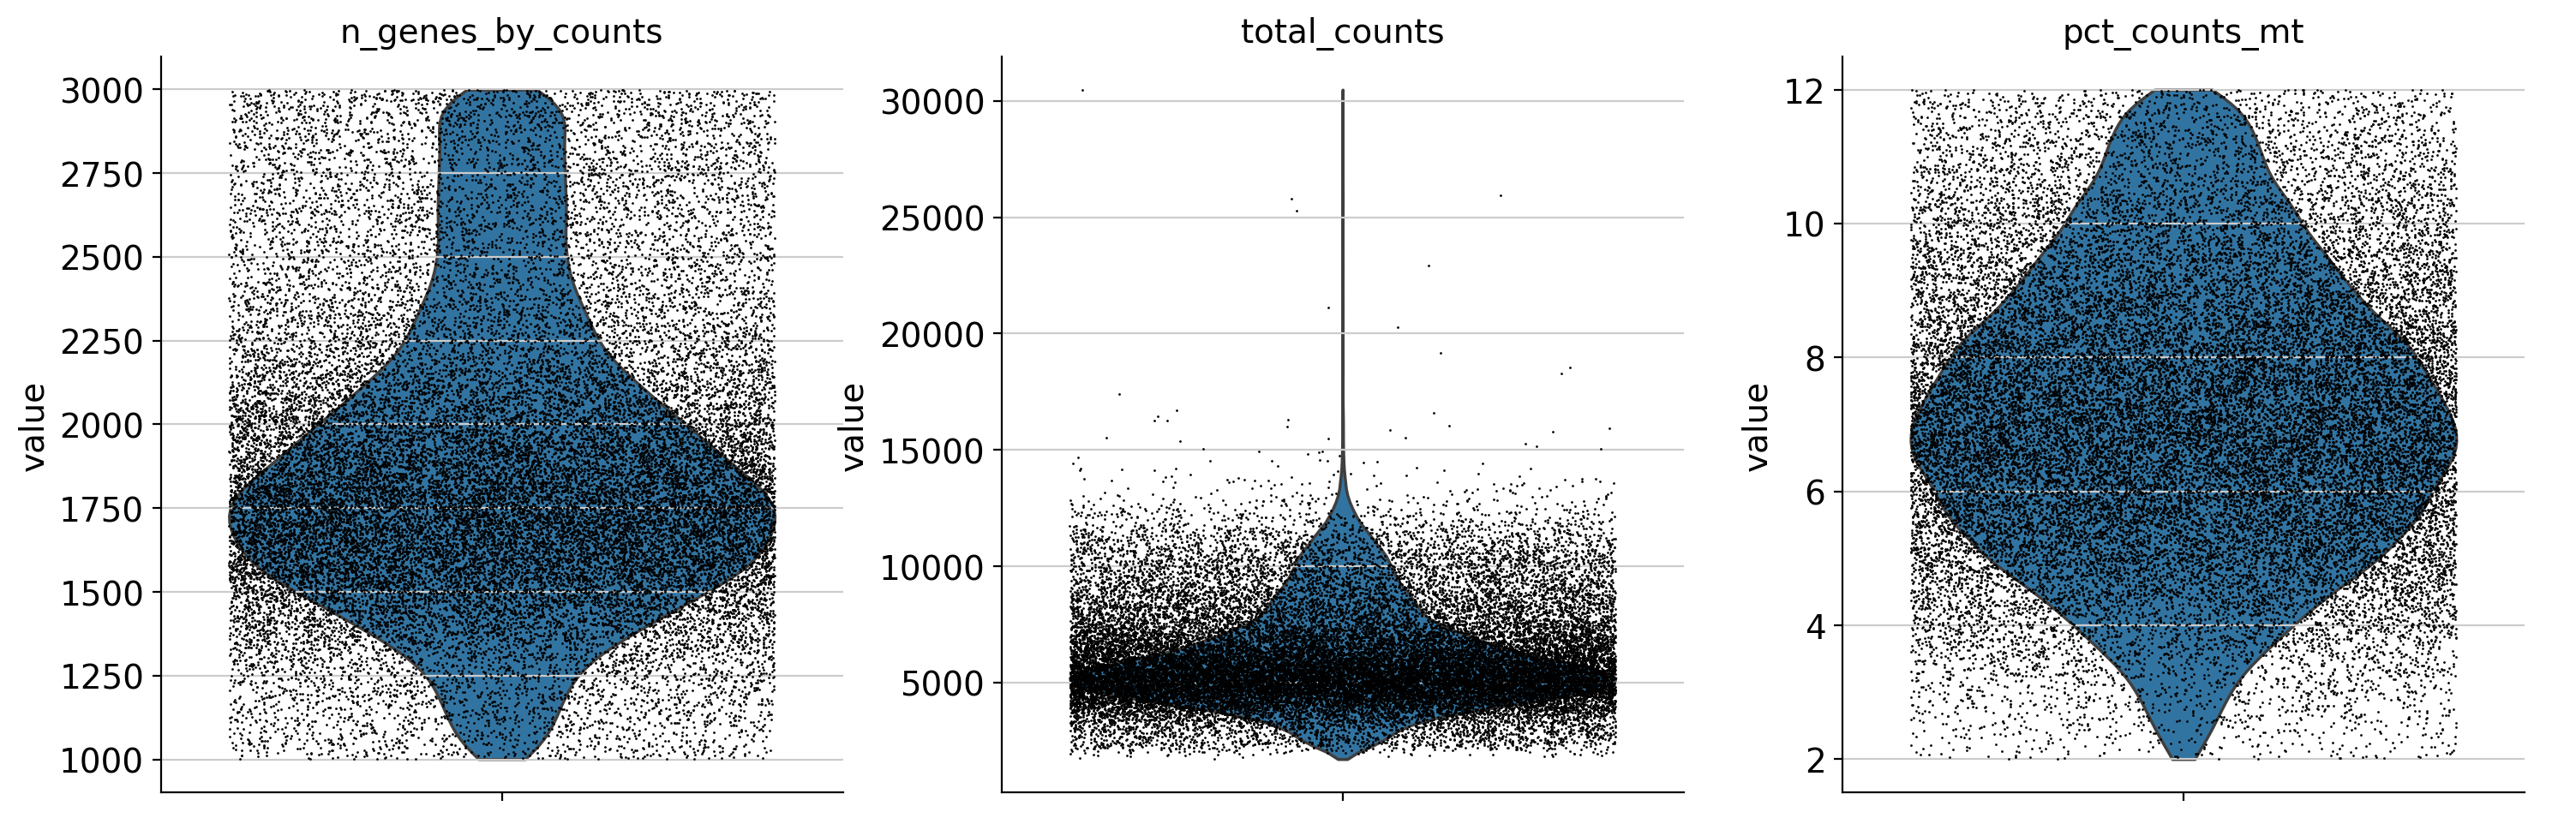

In [12]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

In [ ]:
sc.pp.scrublet(adata)

: 

In [ ]:
adata.obs['predicted_doublet'].value_counts()

predicted_doublet
False    31437
True       250
Name: count, dtype: int64

: 

In [ ]:
adata = adata[adata.obs['predicted_doublet'] == False, :]

: 

In [13]:
sc.pp.normalize_total(adata, target_sum=1e4) # Total-count normalize (library-size correct) the data matrix 𝐗 to 10,000 reads per cell, so that counts become comparable among cells.
sc.pp.log1p(adata) #Logarithmize the data

In [14]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=5, min_disp=0.8) # Identify highly variable genes.
adata = adata[:, adata.var.highly_variable]

In [ ]:
adata

View of AnnData object with n_obs × n_vars = 31437 × 1721
    obs: 'subject_id', 'Condition', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_score', 'predicted_doublet'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'scrublet', 'log1p', 'hvg'

: 

In [16]:
sc.pp.neighbors(adata, n_neighbors=25, n_pcs=9) 
sc.tl.umap(adata)

In [17]:
sc.tl.leiden(adata,resolution = .1) # Cluster cells using the Leiden algorithm.


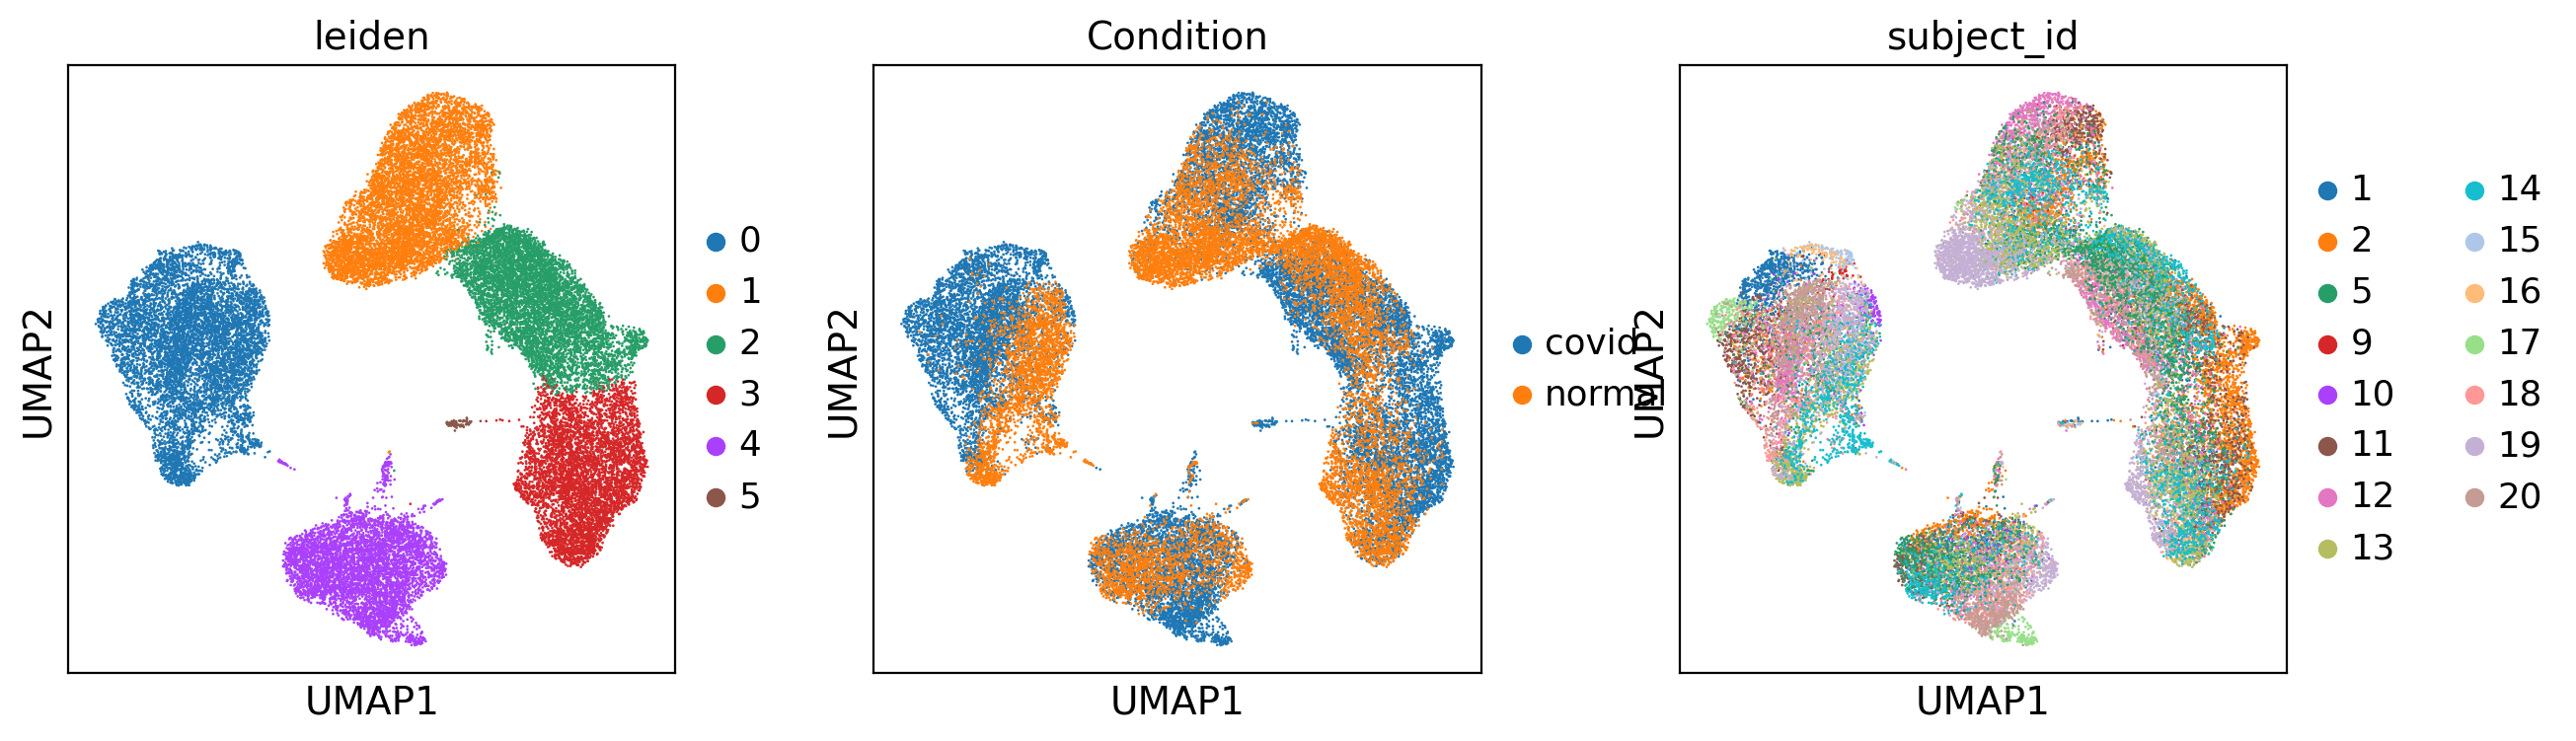

In [18]:
# Compute the neighborhood graph of adata.
 # Embed the neighborhood graph using UMAP.
sc.pl.umap(adata, color=['leiden','Condition','subject_id'],vmax=3) # Plot the UMAP and color by the genes of interest.

In [44]:
types = adata.obs['leiden']
types

AAACCCAGTCTTCGAA-1-0     3
AAACCCAGTTCCGCTT-1-0     0
AAACGAAGTCTACAAC-1-0     1
AAACGCTAGGCTTAAA-1-0     0
AAACGCTCATGACCCG-1-0     2
                        ..
TTTGGTTTCCGCACTT-19-1    0
TTTGTTGAGGCTTTCA-19-1    4
TTTGTTGCAATCTGCA-19-1    1
TTTGTTGTCCTGTAAG-19-1    1
TTTGTTGTCTGGGATT-19-1    1
Name: leiden, Length: 31687, dtype: category
Categories (6, object): ['0', '1', '2', '3', '4', '5']

In [46]:
cell_type_1 = adata.copy()

In [47]:
cell_type_1

AnnData object with n_obs × n_vars = 31687 × 1154
    obs: 'subject_id', 'Condition', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'Condition_colors', 'subject_id_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [48]:
cell_type_1 = cell_type_1[cell_type_1.obs['leiden']=='4']

In [49]:
cell_type_1

View of AnnData object with n_obs × n_vars = 5310 × 1154
    obs: 'subject_id', 'Condition', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'Condition_colors', 'subject_id_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [52]:
cell_type_1.obs['subject_id'].value_counts()

subject_id
5     700
1     643
20    535
12    507
18    496
11    423
2     396
14    363
13    360
19    296
17    218
16    151
10    129
15     79
Name: count, dtype: int64

In [51]:
cell_type_1 = cell_type_1[cell_type_1.obs['subject_id']!='9']

In [16]:
import anndata as ad

In [56]:
import random

In [ ]:
def bootstrap_samples(adata, batch_size = 205, oversample_rate = 2):
    samples = []
    for subject in adata.obs['subject_id'].unique():
        subject_cells = adata[adata.obs['subject_id'] == subject]

        num_cells = subject_cells.shape[0]
        ratio = num_cells/batch_size
        if ratio < 1:
            print('idk do something')
        else:
            num_samples = int(ratio * oversample_rate)
            bootstrapped=[]
            for i in range(num_samples):
                sample = subject_cells[random.sample(range(num_cells),batch_size)]
                sample.obs['sample_id']=f"{subject}_{i}"
                bootstrapped.append(sample)
            samples.extend(bootstrapped)
    bootstrapped_adata = sc.concat(samples, axis = 0, join='outer', merge = 'same')
    return bootstrapped_adata
    

In [ ]:
samples = bootstrap_samples(adata)
bootstrapped_samples = samples.obs['sample_id']


In [57]:
genes = cell_type_1.var['gene_ids']
genes_keys = genes.keys()


indices = random.sample(range(len(genes_keys)),128)
selected_genes_ids = genes_keys[indices]
selected_genes = genes[indices]
dataset = cell_type_1[:,adata.var['gene_ids'].isin(selected_genes)]

In [58]:
dataset

View of AnnData object with n_obs × n_vars = 5296 × 128
    obs: 'subject_id', 'Condition', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'Condition_colors', 'subject_id_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

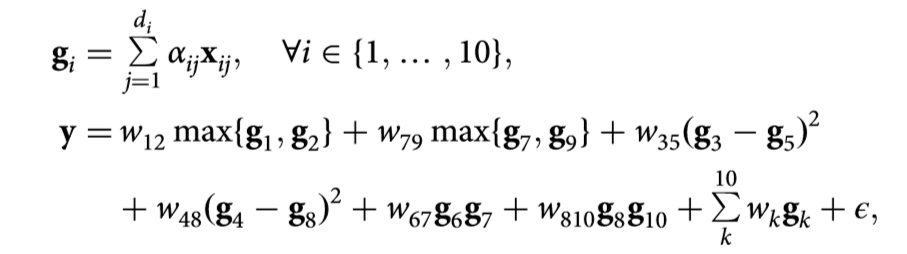

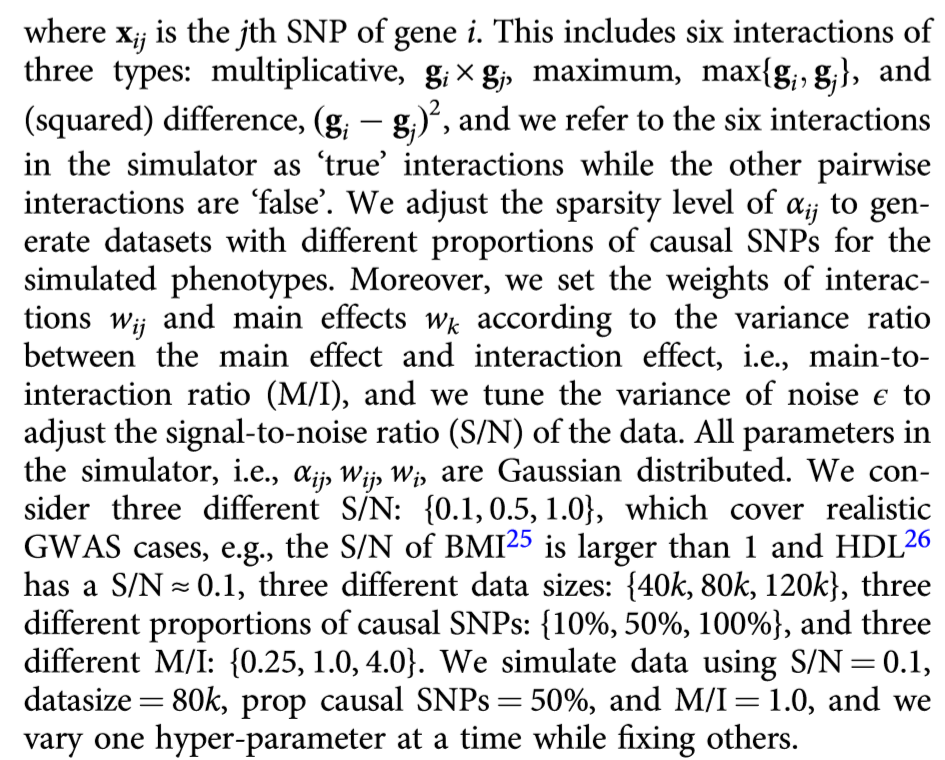

In [106]:
from abc import ABC, abstractmethod
import itertools
import random
import seaborn as sns
import matplotlib.pyplot as plt

class InteractionSimulator:
    class Interaction(ABC):
        def __init__(self,gene_1,gene_2,weight):
            self.gene_1=gene_1
            self.gene_2=gene_2
            self.weight = weight
        @abstractmethod
        def compute_interaction(self):
            pass
        def contribution(self):
            contribution = self.weight*self.compute_interaction()
            return contribution
    class Multiplicative(Interaction):
        def compute_interaction(self):
            return self.gene_1 * self.gene_2         
    class Maximum(Interaction):
        def compute_interaction(self):
            return np.maximum(self.gene_1,self.gene_2)
    class SquaredDifference(Interaction):
        def compute_interaction(self,):
            return (self.gene_1-self.gene_2)**2
    class MainEffect(Interaction):
        def compute_interaction(self):
            return self.gene_1
        
    INTERACTION_CODING = {'0':MainEffect,
                          '1':Multiplicative,
                          '2':Maximum,
                          '3':SquaredDifference,
                          }

    def __init__(self, adata, sample_ids, gene_ids):
        self.sample_ids = sample_ids
        self.gene_ids = gene_ids
        self.adata = adata
    #
    def simulate(self, num_interactions, main_interaction_ratio, signal_noise_ratio, std_dev = 0.001):
        sample_phenotypes = []
        expression = self.adata.X
        interaction_weights = np.random.normal(loc=(1-main_interaction_ratio)/num_interactions, scale=std_dev/num_interactions, size=num_interactions)
        self.plot_weights(interaction_weights)
        main_effect_weights = np.random.normal(loc=main_interaction_ratio/len(self.gene_ids), scale=std_dev/len(self.gene_ids), size=len(self.gene_ids))
        self.plot_weights(main_effect_weights)
        noise = np.random.normal(loc = 0, scale = std_dev*signal_noise_ratio, size = expression.shape[0])
        self.plot_weights(noise)
        #make list of tuples of all gene pairs
        pairs = list(itertools.combinations(self.gene_ids,2))
        #randomly sample interacting gene pairs
        interacting_genes = random.sample(pairs,num_interactions)
        #interaction codes
        interaction_codes = [random.randint(1,3)for _ in range(num_interactions)]
        interactions = []

        for genes, code, weight in zip(interacting_genes,interaction_codes,interaction_weights):
            interaction = self.INTERACTION_CODING[f"{code}"]
            gene_0_loc = self.adata.var.index.get_loc(genes[0])
            gene_1_loc = self.adata.var.index.get_loc(genes[1])
            gene_0_expression = expression[:,gene_0_loc].toarray()
            gene_1_expression = expression[:,gene_1_loc].toarray()
            self.plot_weights(gene_0_expression)
            interaction_instance = interaction(gene_0_expression,gene_1_expression,weight)
            interactions.append(interaction_instance)
        #effect contributions
        interaction_contribution = np.array([interaction.contribution() for interaction in interactions]).squeeze()
        interaction_contribution = np.sum(interaction_contribution,axis=0)
        print(f"{np.min(interaction_contribution)}: min, max:{np.max(interaction_contribution)}")
        interaction_contribution = np.transpose(interaction_contribution)
        print(interaction_contribution.shape)
        self.plot_weights(interaction_contribution)
        main_effect = expression*main_effect_weights
        print(main_effect.shape)
        #maineffect_contribution = np.sum(main_effect,axis=0)
        print(main_effect.shape)
        self.plot_weights(main_effect)
        cell_phenotypes = interaction_contribution + main_effect + noise
        self.plot_weights(cell_phenotypes)
        self.adata.obs['cell_phenotypes'] = cell_phenotypes

        #calculate mean phenotype for cell in a sample
        for i, sample_id in enumerate(self.sample_ids.unique()):
            samples = self.adata[self.adata.obs['subject_id'] == sample_id]
            #make sure the division thing here makes sense
            cell_phenotypes = samples.obs['cell_phenotypes'].to_numpy()
            sample_phenotype = np.sum(cell_phenotypes)/samples.shape[0]
            sample_phenotypes.append(sample_phenotype)
            if i % 1000 ==0:
                print(f"finished up to sample: {i}")
        return np.array(sample_phenotypes)
        

    def plot_weights(self, weights):
        plt.plot(weights)
        plt.show()
           




In [61]:
dataset

View of AnnData object with n_obs × n_vars = 5296 × 128
    obs: 'subject_id', 'Condition', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'Condition_colors', 'subject_id_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [62]:
subject_ids = dataset.obs['subject_id']

In [107]:
simulator = InteractionSimulator(sample_ids=subject_ids,gene_ids=selected_genes_ids,adata=dataset)

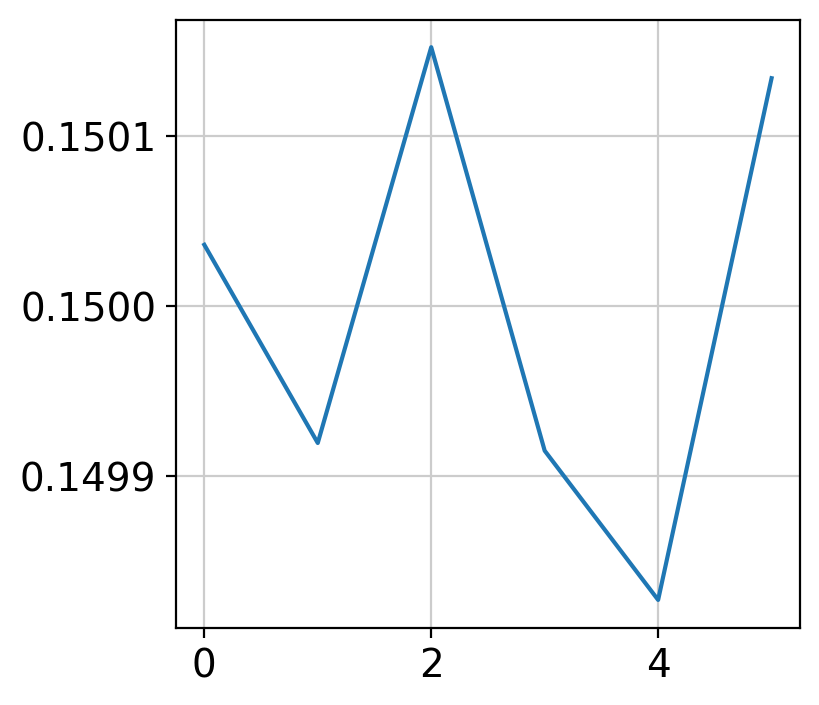

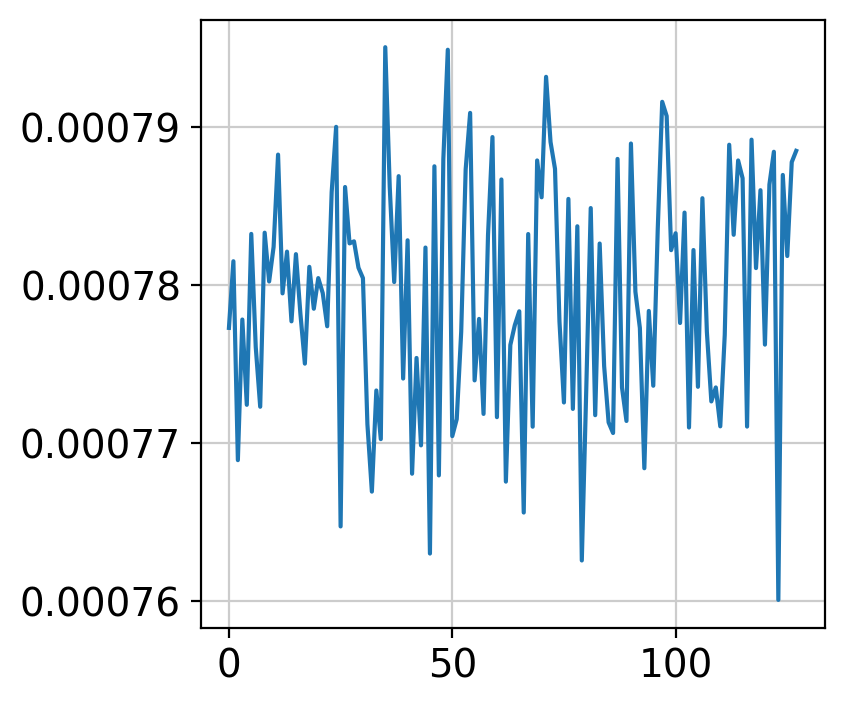

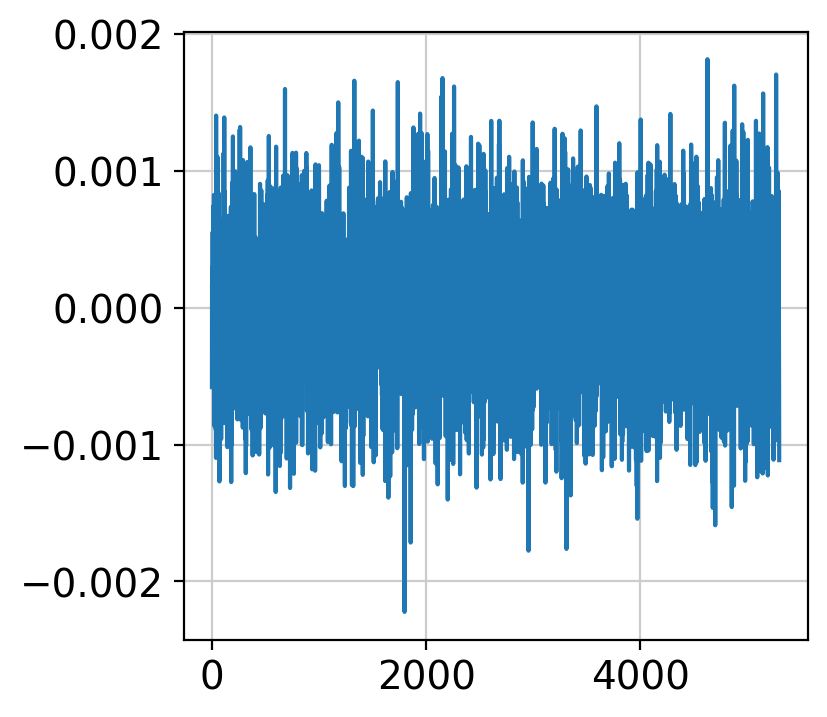

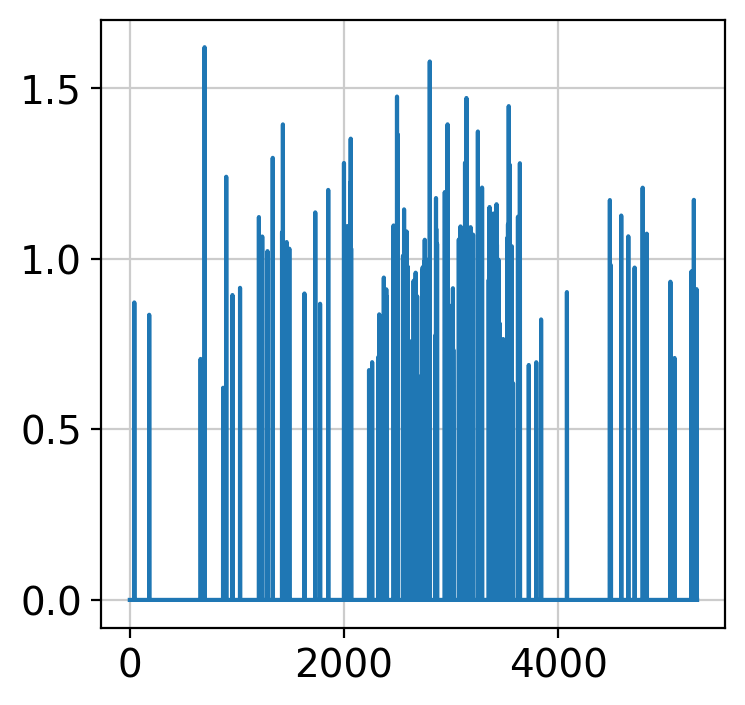

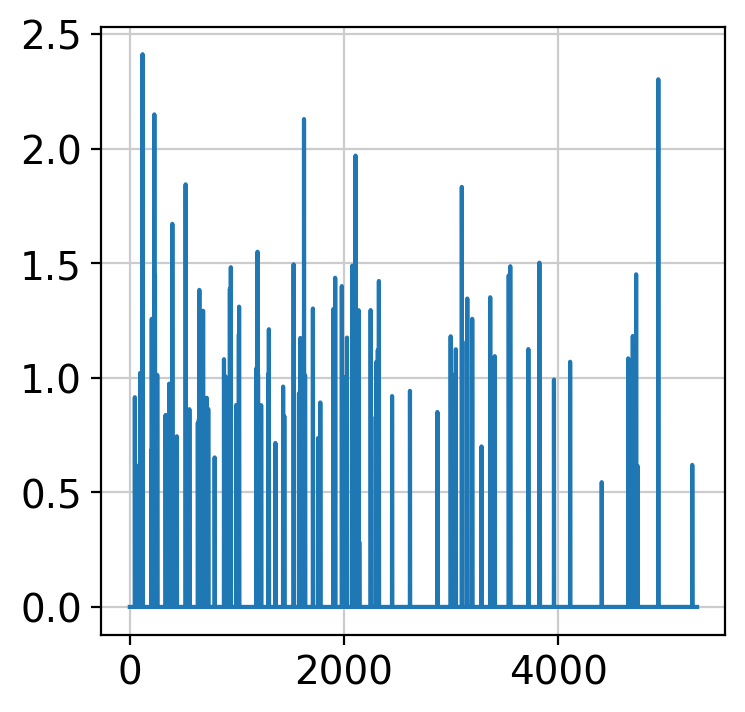

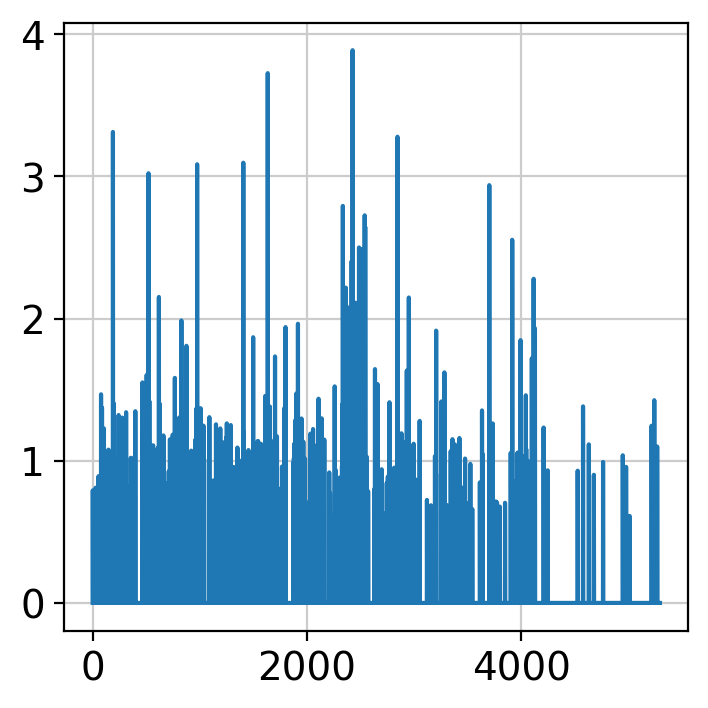

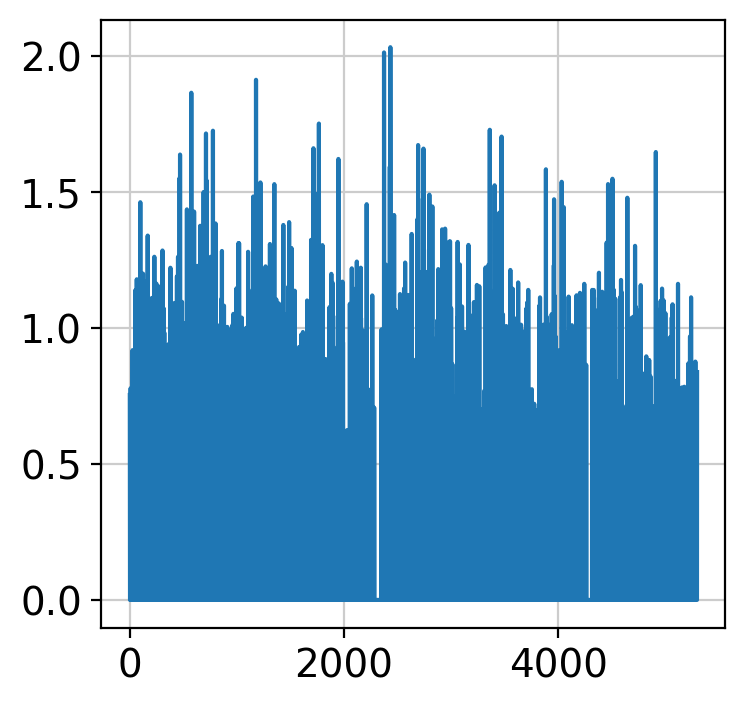

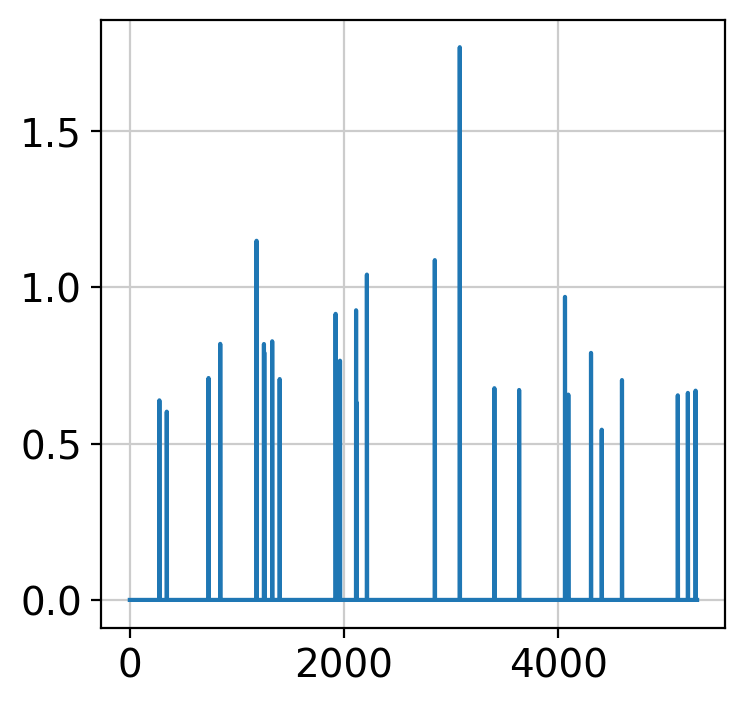

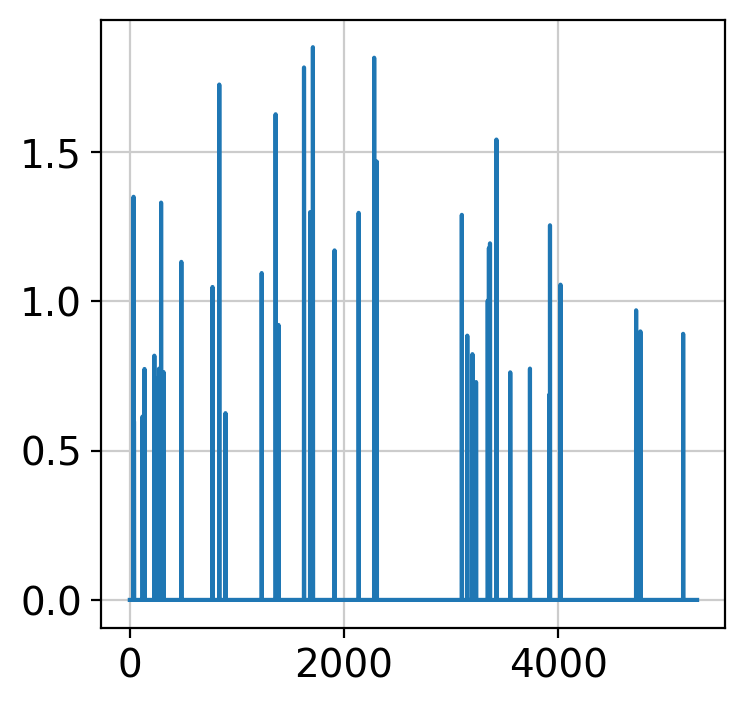

0.0: min, max:2.412081241607666
(5296,)


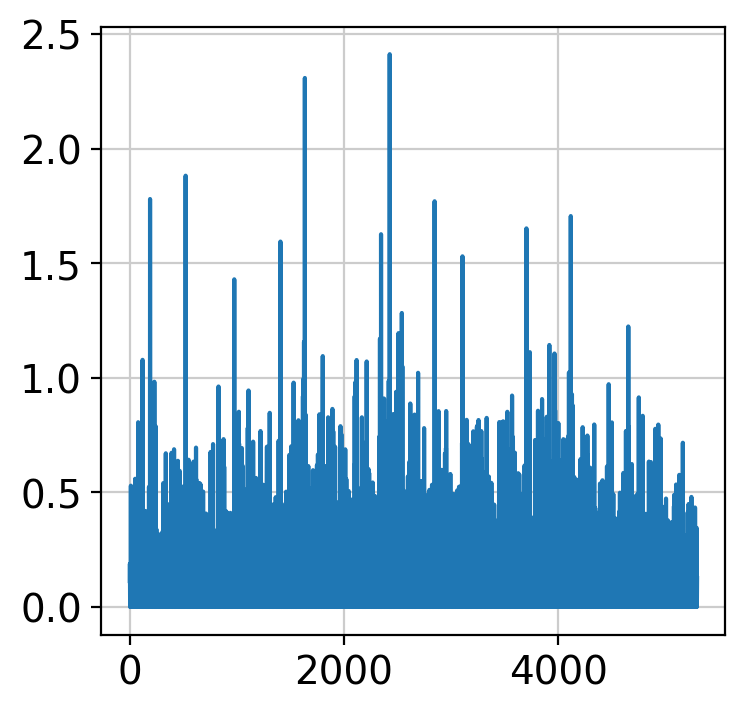

(5296,)
(5296,)


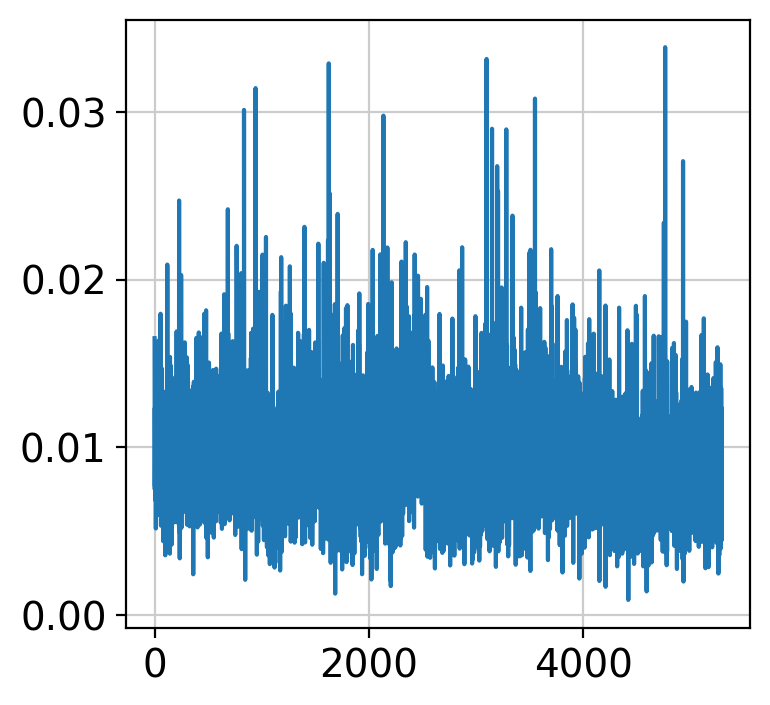

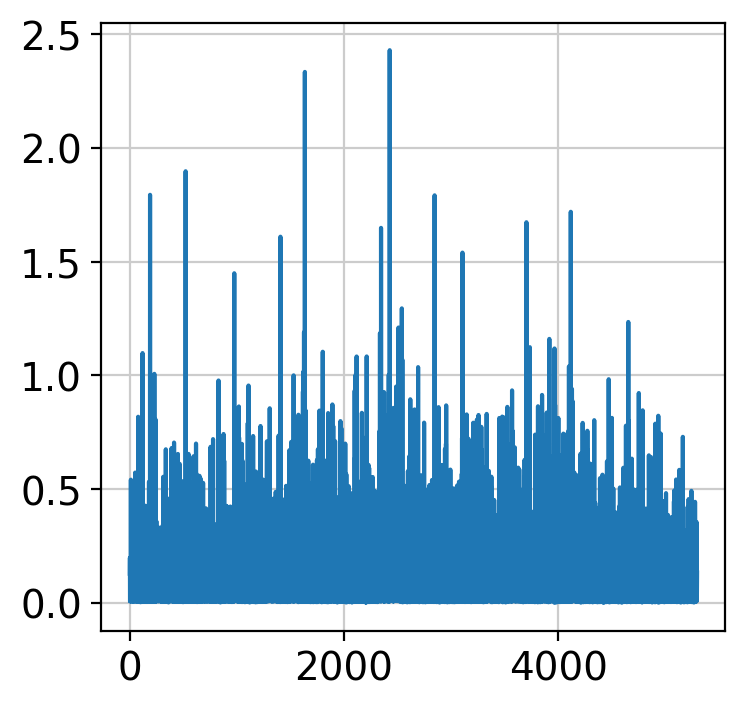

finished up to sample: 0


In [108]:
y = simulator.simulate(num_interactions=6,main_interaction_ratio=.1,signal_noise_ratio=.5)

In [87]:
simulator.sample_ids

AAAGGATTCTTCGACC-1-0      1
AAAGGTAAGCCTAACT-1-0      1
AAAGGTACAGAGAATT-1-0      1
AAAGTCCAGCAGGCAT-1-0      1
AAAGTGAAGCCGATTT-1-0      1
                         ..
TTTACTGCATACTGTG-19-1    19
TTTCCTCTCTACTGCC-19-1    19
TTTCGATCAGTTTGGT-19-1    19
TTTGATCCACACACGC-19-1    19
TTTGTTGAGGCTTTCA-19-1    19
Name: subject_id, Length: 5296, dtype: category
Categories (14, object): ['1', '2', '5', '10', ..., '17', '18', '19', '20']

In [91]:
y.shape

(14,)

In [70]:
dataset.write("./processed_dataset.h5ad")

In [92]:
binary_y = (y >= np.median(y)).astype(int)

In [94]:
phenotype_df = pd.DataFrame({
    'Sample_ID': simulator.sample_ids.unique(),
    'y':y,
    'binary_y':binary_y
})
phenotype_df.to_csv("./phenotypes.csv")

In [100]:
y = phenotype_df[phenotype_df['Sample_ID']=='2']['binary_y']

In [105]:
y.values[0]

2

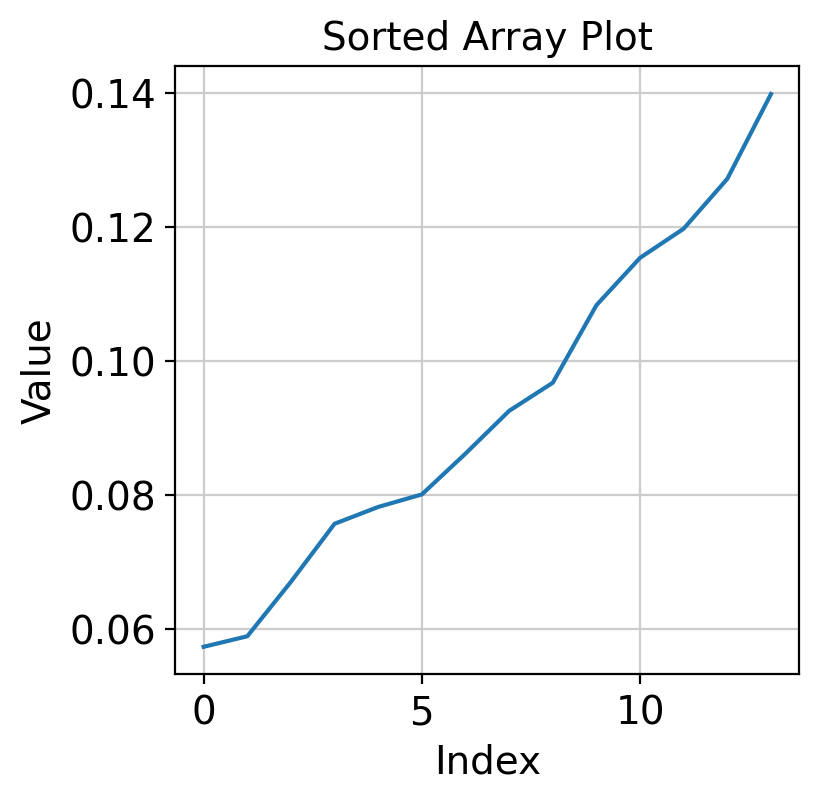

In [97]:
sorted_arr = np.sort(y)

# Plotting the sorted array
plt.plot(sorted_arr)
plt.title('Sorted Array Plot')
plt.xlabel('Index')
plt.ylabel('Value')
plt.show()

In [81]:
obs = dataset.obs

In [82]:
obs.columns

Index(['subject_id', 'Condition', 'batch', 'n_genes', 'n_genes_by_counts',
       'total_counts', 'total_counts_mt', 'pct_counts_mt', 'sample_id',
       'cell_phenotypes'],
      dtype='object')